In [1]:

import numpy             as np
import matplotlib.pyplot as plt
import glob
import h5py as h
import random
%matplotlib inline


In [81]:
def Hist2d(title,Energys,Times,binss,xlimit,ylimit):
    fig,ax = plt.subplots(figsize=(8,8))
    plt.hist2d(Energys,Times,bins=binss,cmap=plt.cm.BuGn_r)
    plt.title(title)

    plt.ylabel("Energy keV",fontsize=26)
    plt.xlabel("Time us",fontsize=26)
    plt.tick_params('both', length=10, width=2, which='major')
    plt.tick_params('both', length=5, width=1, which='minor')
    plt.xticks(fontsize=24)
    plt.yticks(fontsize=24)
    plt.xlim(xlimit)
    plt.ylim(ylimit)
    plt.grid(True)
    plt.tight_layout()

    plt.savefig('/home/ilker/Dropbox/nexus/build/source/'+title + '.png')
    plt.show()
    
def Hist1d(title,Energys,Bins,xlimit,ylimit,limits=False):
    fig, ax = plt.subplots(figsize=(8,8))
    plt.hist(Energys,bins=Bins,alpha=0.7,label=title)
    plt.ylabel("Counts",fontsize=26)
    plt.xlabel("Energy keV",fontsize=26)
    plt.tick_params('both', length=10, width=2, which='major')
    plt.tick_params('both', length=5, width=1, which='minor')
    plt.xticks(fontsize=24)
    plt.yticks(fontsize=24)
    plt.legend(loc='upper right',fontsize=24,shadow=True, fancybox=True)
    #plt.semilogy()
    if(limits):
        plt.xlim(xlimit)
        plt.ylim(ylimit)
    plt.grid(True)
    plt.tight_layout()

    #plt.savefig('/Users/austinmcdonald/Desktop/'+title + '.png')
    plt.show()

def Plot2d(title,x,y):
    fig,ax = plt.subplots(figsize=(8,8))
    plt.plot(x,y)
    plt.scatter(x,y)
    plt.title(title)
    plt.ylabel("Z mm",fontsize=26)
    plt.xlabel("Y mm",fontsize=26)
    plt.tick_params('both', length=10, width=2, which='major')
    plt.tick_params('both', length=5, width=1, which='minor')
    plt.xticks(fontsize=24)
    plt.yticks(fontsize=24)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def Circle(pltX,pltY,title,LarCirR=75,SmallCirR=35,xlimit=100,ylimit=100,FileSave=False):
    fig,ax = plt.subplots(figsize=(8,8))
    plt.title(title)
    plt.plot(pltX,pltY)
    plt.scatter(pltX,pltY)
    circle1 = plt.Circle((0, 0), SmallCirR, color='r',fill=False)
    circle2 = plt.Circle((0, 0), LarCirR, color='k',fill=False)
    ax.add_patch(circle1)
    ax.add_patch(circle2)

    plt.xlim(-xlimit,xlimit)
    plt.ylim(-ylimit,ylimit)

    plt.ylabel("Z (mm)",fontsize=26)
    plt.xlabel("Y (mm)",fontsize=26)
    plt.tick_params('both', length=10, width=2, which='major')
    plt.tick_params('both', length=5, width=1, which='minor')
    plt.xticks(fontsize=24)
    plt.yticks(fontsize=24)
    plt.grid(True)
    plt.tight_layout()
    if(FileSave):
        plt.savefig('/home/ilker/Pictures/Sim/'+title + '.png')
    plt.show()
    

def EnergyAndTracks(file,EventLimit=0,fudicalR=35,fdcount=True,AllEvents=False):
    data = h.File(file,'r')
    TotalEvents=int(data['MC']['configuration'][2][1])
    if(EventLimit>0):
        TotalEvents=EventLimit
    
    theEvents={}
    
    FudicalCount=0
    for Current_Event in range(0,TotalEvents):
        
        Current_Hit_Mask = data['MC']['hits']['event_id'] == Current_Event 

        Current_Particle_Mask = data["MC"]['particles']['event_id'] == Current_Event

        Electron_Mask = data['MC']['particles'][Current_Particle_Mask]['particle_name'] == b'e-'
        
        #Gamma_Mask = data['MC']['particles'][Current_Particle_Mask]['particle_name'] == b'gamma'
        #Gamma_PIDS = data['MC']['particles'][Current_Particle_Mask]['particle_id']
        
        #Electron_MIDS = data["MC"]['particles'][Current_Particle_Mask][Electron_Mask]['mother_id']
        
        #Mothers=np.in1d(Gamma_PIDS,Electron_MIDS)
        
        #MotherEnergy=data['MC']['particles'][Current_Particle_Mask][Mothers]['kin_energy']
        #print(MotherEnergy*1000)
        
        Electron_PIDS = data["MC"]['particles'][Current_Particle_Mask][Electron_Mask]['particle_id']

        A = data["MC"]['hits'][Current_Hit_Mask]['particle_id'] 
        Hit_Electron_Maks = np.in1d(A, Electron_PIDS)
        ElectronData=data["MC"]['hits'][Current_Hit_Mask][Hit_Electron_Maks]
        
        TotalEventEnergy=ElectronData["energy"].sum()*1e3
        Xhits=data["MC"]['hits'][Current_Hit_Mask][Hit_Electron_Maks]["x"]
        Yhits=data["MC"]['hits'][Current_Hit_Mask][Hit_Electron_Maks]["y"]
        Zhits=data["MC"]['hits'][Current_Hit_Mask][Hit_Electron_Maks]["z"]

        #Checking the Radius if in the boundaries
        fRadius=np.sqrt(Yhits*Yhits+Zhits*Zhits)
        fRadius_Mask=fRadius<=fudicalR
        
        TrksCntIntheFudi=np.count_nonzero(fRadius_Mask)
        if(not AllEvents):
            if((TrksCntIntheFudi==0)):
                continue       
        FudicalCount=FudicalCount+1

        Tracks=np.array([Xhits,Yhits,Zhits])
        theEvents[Current_Event]=[Tracks,TotalEventEnergy,TrksCntIntheFudi]
        
        
    if(fdcount):
        print(f" There are only {FudicalCount} out of {TotalEvents} in the fudical volume")
        
    return theEvents

def PlotRandomEvents(theEvents,NPlots,LowE,HighE,EventLimit=0,FileSave=False):

    QualfEnergys=[]    
    for Event in theEvents:
        if(theEvents[Event][1]>=LowE and theEvents[Event][1]<=HighE):
            QualfEnergys.append(Event)
    print(len(QualfEnergys))
    for plot in range(0,NPlots):
        Event=random.choice(QualfEnergys)
        title="Track with " + str(theEvents[Event][1]) + " keV"
        Circle(theEvents[Event][0][1],theEvents[Event][0][2],title,FileSave)
    
        
        
def PlotEnergySpec(theEvents,title,binss=np.arange(1,500,10)):
    Energys=[]
    for Event in theEvents:
        Energys.append(theEvents[Event][1])
    Hist1d(title,Energys,binss,0,0)

    

In [84]:
file = "/home/ilker/Dropbox/nexus/build/source/Cs137_2mm12.h5"
theEvents=EnergyAndTracks(file,1000,fudicalR=35,fdcount=True,AllEvents=False)


 There are only 407 out of 1000 in the fudical volume


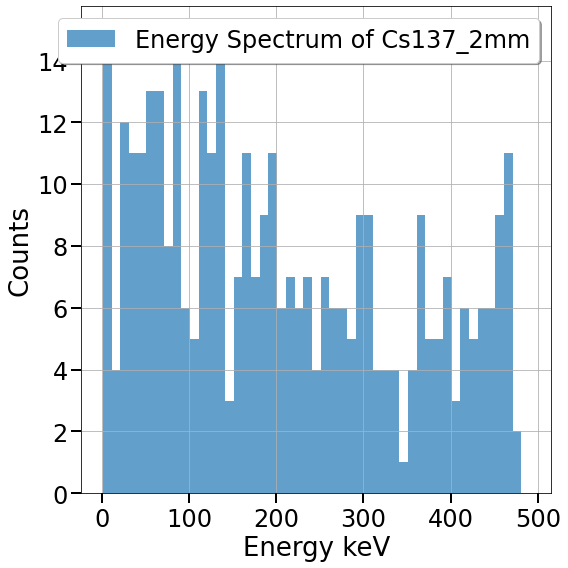

In [85]:
PlotEnergySpec(theEvents,"Energy Spectrum of Cs137_2mm")

In [ ]:
PlotRandomEvents(theEvents,4,100,200,EventLimit=1000)

In [ ]:
file="/home/ilker/Dropbox/nexus/build/source/Ba133_2mm222.h5"
BaE=getEnergys(file)

In [ ]:
Hist1d('Energy Spectrum of Ba133',BaE,np.arange(1,500,10),0,0)
print(len(BaE))

In [ ]:
file="/home/ilker/Dropbox/nexus/build/source/Cs137_2mm12.h5"
BaE2=getEnergys(file)

In [ ]:
A=getTracks("/home/ilker/Dropbox/nexus/build/source/Cs137_2mm12.h5",547)

#B=dicEnergyAndTracks("/home/ilker/Dropbox/nexus/build/source/Cs137_2mm12.h5",1000)


In [ ]:
Plot2d("A Track",A[2],A[1])
Circle(A[2],A[1],"test")
print (A[2])

In [ ]:
PlotRandomEvents("/home/ilker/Dropbox/nexus/build/source/Cs137_2mm12.h5",5,400,EventLimit=1000)